In [1]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from collections import Counter
from data.data_utils import *
from atl_utils import *

In [2]:
### Load arrays
X_desc = joblib.load("./joblib_files/X_desc.joblib")
X_id = joblib.load("./joblib_files/X_id.joblib")
y = joblib.load("./joblib_files/y.joblib")
desc_names = joblib.load("./joblib_files/desc_names.joblib")

In [3]:
# Training source model after removing ProIndan data
X_candidate_desc = prep_array_of_enumerated_candidates([Ni_source_onehot, ligand_desc, additive_ion_onehot, solvent_desc])
BocPro = pd.read_excel("./data/descriptors.xlsx", sheet_name="NHPI", usecols=list(np.arange(2,14))).to_numpy()[0,:]
IndanKat = pd.read_excel("./data/descriptors.xlsx", sheet_name="Katritzky", usecols=list(np.arange(2,14))).to_numpy()[1,:]

X_candidate_desc = np.hstack((
    np.hstack((BocPro, IndanKat)).reshape(1,-1).repeat(X_candidate_desc.shape[0], axis=0),
    X_candidate_desc
))
print(X_candidate_desc.shape)

(18270, 58)


In [4]:
# Removing the 12 reactions between BocPro and Indan in the original dataset
X_desc_noProIndan = np.vstack((
    X_desc[:71, :], X_desc[83:, :]
))
X_id_noProIndan = np.vstack((
    X_id[:71, :], X_id[83:, :]
))
y_noProIndan = np.concatenate((y[:71], y[83:]))

In [5]:
# Adding ProMex reactions
ProMex_data = sheets_to_list_of_dfs("./data/reaction_data.xlsx", ["ProMex"])
X_id_ProMex = ProMex_data[0].iloc[:, 1:-2].to_numpy()
X_desc_ProMex = id_array_to_desc_array(X_id_ProMex, True)

LCyield_ProMex = ProMex_data[0].iloc[:, -1].to_numpy()
y_ProMex = np.zeros_like(LCyield_ProMex)
y_ProMex[np.where(LCyield_ProMex < 7)[0]] = 0
y_ProMex[np.where(LCyield_ProMex >= 7)[0]] = 1

X_desc_source = np.vstack((X_desc_noProIndan, X_desc_ProMex))
y_source = np.concatenate((y_noProIndan, y_ProMex))
print(X_desc_source.shape, y_source.shape)

(223, 58) (223,)


In [6]:
# Training source model
noProIndan_source_model_100_trees = []
for j in range(100) :
    rfc = RandomForestClassifier(n_estimators=100, max_depth=1, random_state=42+j, n_jobs=-1)
    rfc.fit(X_desc_source, y_source)
    noProIndan_source_model_100_trees.append(rfc)

In [7]:
### Extracting rxns between BocPro + Indan from original data
df = sheets_to_list_of_dfs("./data/reaction_data.xlsx", ["Source"])
id_array = df[0].iloc[71:83, 1:-2].to_numpy()

ProIndan_desc = id_array_to_desc_array(id_array, True)
ProIndan_assay_yields = df[0].iloc[71:83, -1].to_numpy()
y_ProIndan = np.zeros(len(ProIndan_assay_yields))
y_ProIndan[np.where(ProIndan_assay_yields >= 9.5)[0]] = 1

In [8]:
target_models = train_target_models(ProIndan_desc, y_ProIndan, 100, 15, max_depth=1)

In [9]:
# Randomly mix and matching source and target models
combined_models_100_trees = combine_two_model_list_shuffled(
    noProIndan_source_model_100_trees, 
    target_models
)

In [10]:
# Removing the 12 that has been tested as a part of the source data from all possible candidates
X_candidate_id = prep_array_of_enumerated_candidates(COMPONENT_ID_ARRAY)
X_candidate_desc = id_array_to_desc_array(
    np.hstack((
        np.ones(X_candidate_id.shape[0]).reshape(-1, 1),
        np.ones(X_candidate_id.shape[0]).reshape(-1, 1)*2,
        X_candidate_id
    )),
    True
)
print(X_candidate_id.shape, X_candidate_desc.shape)

X_candidate_id, X_candidate_desc = remove_prev_sampled_rxns(
    X_candidate_id, X_candidate_desc, id_array[:, 2:]
)
print(X_candidate_id.shape, X_candidate_desc.shape)

(18270, 5) (18270, 58)
(18258, 5) (18258, 58)


In [11]:
# Suggestions from 100 trees with 24 votes
count_list = count_num_topN_suggestions(
    [combined_models_100_trees], 
    X_candidate_desc, 
    24
)
print_suggestions(X_candidate_id, count_list[0], 24)

[NiBr2(glyme),  4CF3,                    KBr,                      THF] 99
[NiBr2(glyme),  4CF3,                    KBr,                  Dioxane] 96
[NiBr2(glyme),  4CF3,                    KCl,                      THF] 89
[NiBr2(glyme),  4CF3,                    KBr,                     CPME] 86
[NiBr2(glyme),  4CF3,                     KI,                      THF] 84
[NiBr2(glyme),  4CF3,                    KBr,                  Acetonitrile] 81
[NiBr2(glyme),  4CF3,                    KCl,                  Dioxane] 76
[NiBr2(glyme),  4CF3,                     KI,                  Dioxane] 72
[NiBr2(glyme),  4CF3,                    KBr,                    glyme] 69
[NiBr2(glyme),  4CF3,                  TBABr,                      THF] 55
[NiBr2(glyme),  4CF3,                  MgBr2,                      THF] 55
[NiBr2(glyme),  4CF3,                    KBr,                   tBuOMe] 54
[NiBr2(glyme),  4CF3,                    KCl,                  Acetonitrile] 53
[NiBr2(glyme), 

In [12]:
# Suggestions from 100 trees with 6 votes
count_list = count_num_topN_suggestions(
    [combined_models_100_trees], 
    X_candidate_desc, 
    6
)
print_suggestions(X_candidate_id, count_list[0], 12)

[NiBr2(glyme),  4CF3,                    KBr,                      THF] 92
[NiBr2(glyme),  4CF3,                    KBr,                  Dioxane] 69
[NiBr2(glyme),  4CF3,                    KCl,                      THF] 51
[NiBr2(glyme),  4CF3,                     KI,                      THF] 46
[NiBr2(glyme),  4CF3,                    KBr,                  Acetonitrile] 39
[NiBr2(glyme),  4CF3,                    KBr,                     CPME] 31
[NiBr2(glyme),  4CF3,                    KCl,                  Dioxane] 28
[NiBr2(glyme),  4CF3,                     KI,                  Dioxane] 22
[NiBr2(glyme),  4CF3,                    KBr,                    glyme] 21
[NiBr2(glyme),  4CF3,                  TBABr,                      THF] 18
[NiBr2(glyme),  4CF3,                  MgBr2,                      THF] 17
[NiBr2(glyme),  4CF3,                    KBr,                   tBuOMe] 12


## Second iteration

In [13]:
### Array preparation of experiments done in the second iteration
second_df = sheets_to_list_of_dfs("./data/reaction_data.xlsx", ["ProIndan"])
second_id_array = second_df[0].iloc[:6, 1:-2].to_numpy()
second_ProInd_desc = id_array_to_desc_array(second_id_array, True)

second_assay_yield = second_df[0].iloc[:6, -1].to_numpy()
second_y = np.zeros(len(second_assay_yield))
second_y[np.where(second_assay_yield >= 32)[0]] = 1
print(second_y)

[1. 1. 1. 0. 0. 1.]


In [14]:
second_target_models = train_target_models(second_ProInd_desc, second_y, 100, 15, max_depth=1)
second_combined_models = combine_two_model_list_shuffled(combined_models_100_trees, second_target_models)

In [15]:
# Removing the reactions conducted in first iteration
print("Before removing previous samples: ", X_candidate_id.shape, X_candidate_desc.shape)
X_candidate_id, X_candidate_desc = remove_prev_sampled_rxns(
    X_candidate_id, X_candidate_desc, second_id_array[:, 2:]
)
print("After removing previous samples: ", X_candidate_id.shape, X_candidate_desc.shape)

Before removing previous samples:  (18258, 5) (18258, 58)
After removing previous samples:  (18252, 5) (18252, 58)


In [16]:
second_rxn_counter2 = Counter()
for rfc in second_combined_models :
    proba = rfc.predict_proba(X_candidate_desc)[:,1]
    best_rxns = np.argsort(proba)[::-1][:24]
    second_rxn_counter2.update(best_rxns)
print_suggestions(X_candidate_id, second_rxn_counter2, 24)

[NiBr2(glyme),  4CF3,                  ZnCl2,                      THF] 81
[NiBr2(glyme),  4CF3,                  MgCl2,                      THF] 78
[NiBr2(glyme),  4CF3,                  TMSCl,                      THF] 77
[NiBr2(glyme),  4CF3,                  TBACl,                      THF] 77
[NiBr2(glyme),  4CF3,                   NaCl,                      THF] 77
[NiBr2(glyme),  4CF3,                   TBAI,                      THF] 74
[NiBr2(glyme),  4CF3,                    NaI,                      THF] 73
[        NiI2,  4CF3,                     KI,                      THF] 63
[    Ni(COD)2,  4CF3,                     KI,                      THF] 63
[NiBr2(glyme),  4CF3,            succinimide,                      THF] 62
[NiBr2(glyme),  4CF3,                    KCl,                     CPME] 61
[        NiI2,  4CF3,                    KCl,                      THF] 60
[NiBr2(glyme),  4CF3,                   None,                      THF] 59
[NiBr2(glyme),  4CF3,    

## Third iteration

In [17]:
### Array preparation of experiments done in the second iteration
third_df = sheets_to_list_of_dfs("./data/reaction_data.xlsx", ["ProIndan"])
third_id_array = second_df[0].iloc[6:12, 1:-2].to_numpy()
third_ProInd_desc = id_array_to_desc_array(third_id_array, True)

third_assay_yield = third_df[0].iloc[6:12, -1].to_numpy()
third_y = np.zeros(len(third_assay_yield))
third_y[np.where(third_assay_yield >= 32)[0]] = 1
# Augmenting the single positive label
third_y = np.concatenate((third_y, [1]))
third_ProInd_desc = np.vstack((third_ProInd_desc, third_ProInd_desc[-1,:]))
print(third_y)
print(third_ProInd_desc.shape)

[0. 0. 0. 0. 0. 1. 1.]
(7, 58)


In [18]:
third_target_models = train_target_models(third_ProInd_desc, third_y, 100, 15, max_depth=1)
third_combined_models = combine_two_model_list_shuffled(second_combined_models, third_target_models)

In [19]:
# Removing the reactions conducted in first iteration
print("Before removing previous samples: ", X_candidate_id.shape, X_candidate_desc.shape)
X_candidate_id, X_candidate_desc = remove_prev_sampled_rxns(
    X_candidate_id, X_candidate_desc, third_id_array[:, 2:]
)
print("After removing previous samples: ", X_candidate_id.shape, X_candidate_desc.shape)

Before removing previous samples:  (18252, 5) (18252, 58)
After removing previous samples:  (18246, 5) (18246, 58)


In [20]:
third_rxn_counter = Counter()
for rfc in third_combined_models :
    proba = rfc.predict_proba(X_candidate_desc)[:,1]
    best_rxns = np.argsort(proba)[::-1][:24]
    third_rxn_counter.update(best_rxns)
print_suggestions(X_candidate_id, third_rxn_counter, 24)

[    Ni(COD)2,  4CF3,                  TMSCl,                      THF] 98
[        NiI2,  4CF3,                  TMSCl,                      THF] 98
[NiCl2(glyme),  4CF3,                  TMSCl,                      THF] 96
[NiBr2(glyme),  4CF3,                  TMSCl,                     CPME] 95
[   Ni(acac)2,  4CF3,                  TMSCl,                      THF] 83
[    Ni(COD)2,  4CF3,                  TMSCl,                     CPME] 72
[        NiI2,  4CF3,                  TMSCl,                     CPME] 72
[NiBr2(glyme),  4CF3,                  TMSCl,                    glyme] 71
[NiCl2(glyme),  4CF3,                  TMSCl,                     CPME] 67
[NiBr2(glyme),  4CF3,                  ZnCl2,                      THF] 64
[NiBr2(glyme),  4CF3,                  TMSCl,                     Bu2O] 63
[NiBr2(glyme),  4CF3,                    KCl,                     CPME] 59
[NiBr2(glyme),  4CF3,                  TMSCl,                   tBuOMe] 59
[        NiI2,  4CF3,    

## Model Analysis

In [21]:
source_desc_utilized = get_descriptors_used_by_target_models(noProIndan_source_model_100_trees, desc_names)
first_desc_utilized = get_descriptors_used_by_target_models(target_models, desc_names)
second_desc_utilized = get_descriptors_used_by_target_models(second_target_models, desc_names)
third_desc_utilized = get_descriptors_used_by_target_models(third_target_models, desc_names)
desc_utilized_by_batch = [source_desc_utilized, first_desc_utilized, second_desc_utilized, third_desc_utilized]

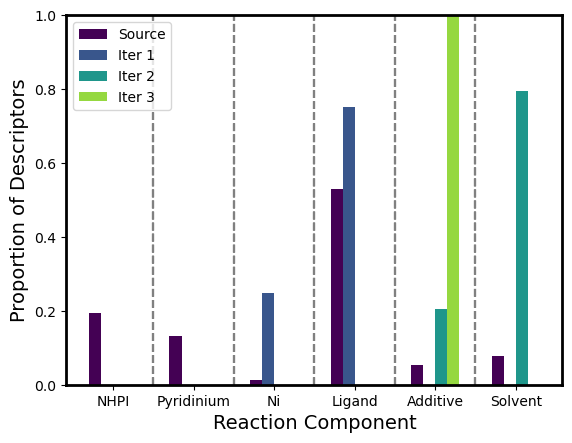

In [22]:
desc_index = [desc_names.index('Katritzky E_red'), desc_names.index('NiCl2'), desc_names.index('Ligand Ni-X'), desc_names.index('Cl'), desc_names.index('Solvent HansenD')]
prev_ind = 0
position = [-1.5, -0.5, 0.5, 1.5]
width = 0.15
bar_colors = ["#440154", "#39568C", "#1F968B", "#95D840"]
bar_labels = ["Source", "Iter 1", "Iter 2", "Iter 3"]
component_names = ["NHPI", "Pyridinium", "Ni", "Ligand", "Additive", "Solvent"]

fig, ax = plt.subplots()
for i, desc_batch in enumerate(desc_utilized_by_batch) : 
    bars = []
    bar_x_pos = [x + position[i]*width for x in range(len(desc_index)+1)] 
    for j, div_ind in enumerate(desc_index):
        bars.append(sum(desc_batch[prev_ind:div_ind])/sum(desc_batch))
        if j == len(desc_index) - 1:
            bars.append(sum(desc_batch[div_ind:])/sum(desc_batch))
        ax.axvline(j+0.5, 0, 1, ls="--", c='grey')
        prev_ind = div_ind 
    ax.bar(bar_x_pos, bars, label=bar_labels[i], color=[bar_colors[i]]*len(bars), width=width, )
ax.set_xticks(np.arange(6))
ax.set_xticklabels(component_names)
ax.set_xlabel("Reaction Component", fontsize=14)
ax.set_ylim([0,1])
ax.set_yticks(0.2*np.arange(6))
ax.set_ylabel("Proportion of Descriptors", fontsize=14)
ax.set_yticklabels([round(0.2*x, 1) for x in np.arange(6)])

ax.legend(loc="upper left")
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)